<a href="https://colab.research.google.com/github/adeiskandarzulkarnaen/prediksi-ntp/blob/main/src-py/ntpjabar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Farmer's Term Of Trade with Neural Networks (DNN only)

 In particular, we will train on the ntp data sourced from official government portal [prov. Jawa Barat](https://opendata.jabarprov.go.id/id/dataset/nilai-tukar-petani-ntp-berdasarkan-kategori-bulan-di-jawa-barat): a monthly record of ntp numbers from January 2006 to December 2019. We will first build a deep neural network here composed of dense layers.

Let's begin!

## Imports

We will use the addition of the [csv](https://docs.python.org/3/library/csv.html) module. We will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

We will be plotting several graphs in this notebook so it's good to have a utility function for that. The following code will visualize numpy arrays into a graph using Pyplot's plot() method. The unit for this training we can think of as months, starting from jan 2006 to dec 2019. The y-axis will contain the measured values at each time step.

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)
    # plt.xticks(range(0, max(x) + 12, 12))

    # Label the y-axis
    plt.ylabel(ylabel)
    # plt.ylim(50, max(y) + 10)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

we can now download the dataset and inspect the contents. The link in class is from ade's repo but we also hosted it in the link below.

In [3]:
# Download the dataset
!wget https://raw.githubusercontent.com/adeiskandarzulkarnaen/prediksi-ntp/main/src-py/ntpjabar.csv


--2024-01-09 03:52:16--  https://raw.githubusercontent.com/adeiskandarzulkarnaen/prediksi-ntp/main/src-py/ntpjabar.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3075 (3.0K) [text/plain]
Saving to: ‘ntpjabar.csv’

ntpjabar.csv        100%[===================>]   3.00K  --.-KB/s    in 0s      

2024-01-09 03:52:16 (51.5 MB/s) - ‘ntpjabar.csv’ saved [3075/3075]



Running the cell below, we'll see that there are only three columns in the dataset:
1. no column containing the number of data
2. Year and Month which has the format `YYYY-MM`
3. NTP value

In [4]:
# Preview the dataset
!head ntpjabar.csv

no,year-month,ntp value
1,2006-01,113.67
2,2006-02,113.10
3,2006-03,113.58
4,2006-04,112.26
5,2006-05,111.33
6,2006-06,112.86
7,2006-07,115.02
8,2006-08,117.55
9,2006-09,116.83


For this lab, we will only need the time steps and the ntp values. We will load those into memory and convert it to arrays that represents a time series.

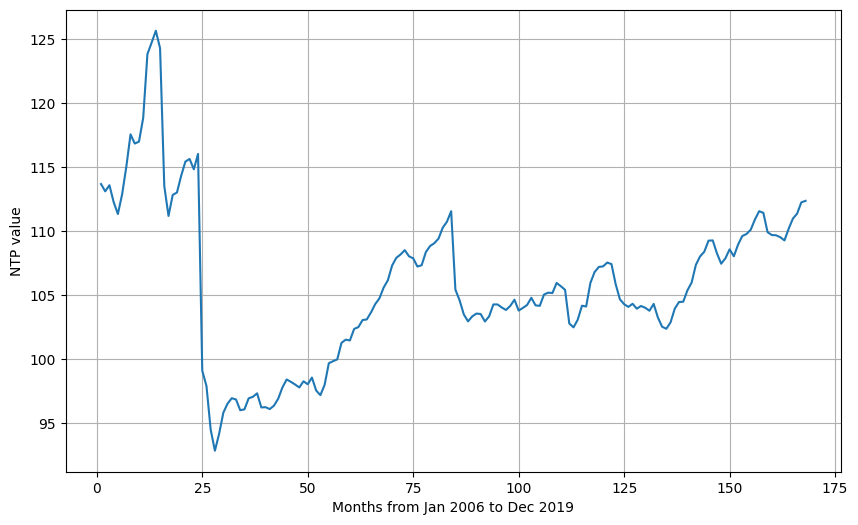

In [5]:
# Initialize lists
time_step = []
ntp_values = []

# Open CSV file
with open('./ntpjabar.csv') as csvfile:
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and ntp values to lists
  for row in reader:
    time_step.append(int(row[0]))
    ntp_values.append(float(row[2]))


# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(ntp_values)

# Preview the data
plot_series(time, series, xlabel='Months from Jan 2006 to Dec 2019', ylabel='NTP value')

## Split the Dataset

Next, we will split the dataset into training and validation sets. There are 168 points in the dataset and we will use the first 144 for training.

In [6]:
# Define the split time
split_time = 144

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

We can then prepare the dataset windows. The window size is set to 12 points (equal to 1 year) but feel free to change later on if we want to experiment.

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
# Parameters
window_size = 12
batch_size = 14
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

The model will be 3-layer dense network as shown below.

In [9]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(11, activation="relu"),
    tf.keras.layers.Dense(11, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 11)                143       
                                                                 
 dense_2 (Dense)             (None, 11)                132       
                                                                 
 dense_3 (Dense)             (None, 1)                 12        
                                                                 
Total params: 443 (1.73 KB)
Trainable params: 443 (1.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tune the Learning Rate

We can pick a learning rate by running the learning rate scheduler code.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 3s 10ms/step - loss: 148.7639 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 148.6772 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 148.5447 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 148.3828 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 148.1971 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 147.9870 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 147.7511 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 8ms/step - loss: 147.4839 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 147.1851 - lr: 2.5119e-08
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 146.8501 - lr: 2.8184e-08
Epoch 1

(1e-08, 0.001, 0.0, 100.0)

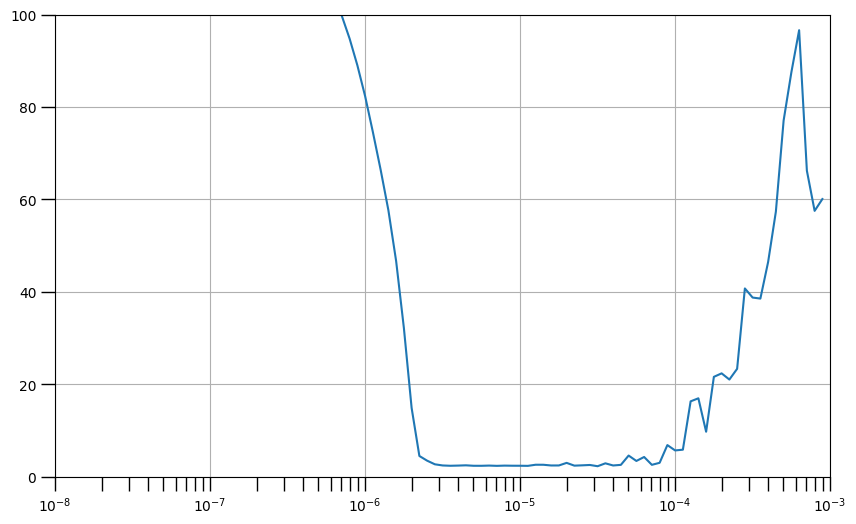

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once we've picked a learning rate, we can rebuild the model and start training.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(11, activation="relu"),
    tf.keras.layers.Dense(11, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [13]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
10/10 [==============================] - 2s 8ms/step - loss: 83.4934 - mae: 83.9934 - mape: 80.5442
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 31.8376 - mae: 32.3369 - mape: 30.8914
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 14.4627 - mae: 14.9590 - mape: 14.4056
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 6.9825 - mae: 7.4722 - mape: 7.2397
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 3.4593 - mae: 3.9369 - mape: 3.7927
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 2.7426 - mae: 3.2091 - mape: 3.1061
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 2.3991 - mae: 2.8433 - mape: 2.7611
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 2.5086 - mae: 2.9683 - mape: 2.8767
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 2.3943 - mae: 2.8541 - mape: 2.7647
Epoch 10/1

## Model Prediction

Now see if the model generates good results. We should see the predictions follow the shape of the ground truth with an MAE.

In [14]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

2/2 [==============================] - 0s 11ms/step


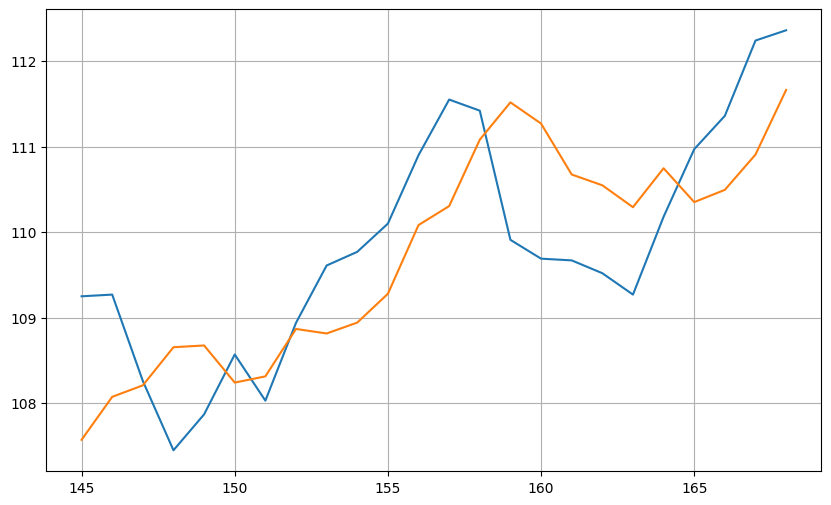

In [15]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [16]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.86596423
